<a href="https://colab.research.google.com/github/sauravrox/image-text-detection/blob/main/Text_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import csv
import gzip
import collections
import re
import io
import json
import xml.etree.ElementTree as ET

import requests
import pandas as pd

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
xml_path = os.path.join('/content/drive/MyDrive/image/drugbank.xml.gz')
with gzip.open(xml_path) as xml_file:
    tree = ET.parse(xml_file)
root = tree.getroot()

In [ ]:
ns = '{http://www.drugbank.ca}'
inchikey_template = "{ns}calculated-properties/{ns}property[{ns}kind='InChIKey']/{ns}value"
inchi_template = "{ns}calculated-properties/{ns}property[{ns}kind='InChI']/{ns}value"

rows = list()
for i, drug in enumerate(root):
    row = collections.OrderedDict()
    assert drug.tag == ns + 'drug'
    row['type'] = drug.get('type')
    row['drugbank_id'] = drug.findtext(ns + "drugbank-id[@primary='true']")
    row['name'] = drug.findtext(ns + "name")
    row['description'] = drug.findtext(ns + "description")
    row['groups'] = [group.text for group in
        drug.findall("{ns}groups/{ns}group".format(ns = ns))]
    row['atc_codes'] = [code.get('code') for code in
        drug.findall("{ns}atc-codes/{ns}atc-code".format(ns = ns))]
    row['categories'] = [x.findtext(ns + 'category') for x in
        drug.findall("{ns}categories/{ns}category".format(ns = ns))]
    row['inchi'] = drug.findtext(inchi_template.format(ns = ns))
    row['inchikey'] = drug.findtext(inchikey_template.format(ns = ns))
    
    # Add drug aliases
    aliases = {
        elem.text for elem in 
        drug.findall("{ns}international-brands/{ns}international-brand".format(ns = ns)) +
        drug.findall("{ns}synonyms/{ns}synonym[@language='English']".format(ns = ns)) +
        drug.findall("{ns}international-brands/{ns}international-brand".format(ns = ns)) +
        drug.findall("{ns}products/{ns}product/{ns}name".format(ns = ns))

    }
    aliases.add(row['name'])
    row['aliases'] = sorted(aliases)

    rows.append(row)

In [ ]:
alias_dict = {row['drugbank_id']: row['aliases'] for row in rows}
with open('/content/drive/MyDrive/image/aliases.json', 'w') as fp:
    json.dump(alias_dict, fp, indent=2, sort_keys=True)

In [ ]:
def collapse_list_values(row):
    for key, value in row.items():
        if isinstance(value, list):
            row[key] = '|'.join(value)
    return row

rows = list(map(collapse_list_values, rows))
columns = ['name','description']
df1 = pd.DataFrame.from_dict(rows)[columns]
df1.head()

,name,description
0,Lepirudin,Lepirudin is identical to natural hirudin exce...
1,Cetuximab,Epidermal growth factor receptor binding FAB. ...
2,Dornase alfa,Dornase alfa is a biosynthetic form of human d...
3,Denileukin diftitox,A recombinant DNA-derived cytotoxic protein co...
4,Etanercept,Dimeric fusion protein consisting of the extra...


In [ ]:
df2=pd.read_csv('/content/drive/MyDrive/image/drugsComTrain_raw.csv')
frames = [df1, df2]
result = pd.concat(frames)
result

,name,description
0,Lepirudin,Lepirudin is identical to natural hirudin exce...
1,Cetuximab,Epidermal growth factor receptor binding FAB. ...
2,Dornase alfa,Dornase alfa is a biosynthetic form of human d...
3,Denileukin diftitox,A recombinant DNA-derived cytotoxic protein co...
4,Etanercept,Dimeric fusion protein consisting of the extra...
...,...,...
161292,Campral,Alcohol Dependence
161293,Metoclopramide,Nausea/Vomiting
161294,Orencia,Rheumatoid Arthritis
161295,Thyroid desiccated,Underactive Thyroid


In [ ]:
!pip install tesseract-ocr
!pip install libtesseract-dev
!pip install pytesseract

  ERROR: Failed building wheel for tesseract-ocr
  Running setup.py clean for tesseract-ocr
Failed to build tesseract-ocr
    Running setup.py install for tesseract-ocr ... error
ERROR: Command errored out with exit status 1: /usr/bin/python3 -u -c 'import io, os, sys, setuptools, tokenize; sys.argv[0] = '"'"'/tmp/pip-install-a7e7r53i/tesseract-ocr_a8769ff10cb241a8896fe47f552a86df/setup.py'"'"'; __file__='"'"'/tmp/pip-install-a7e7r53i/tesseract-ocr_a8769ff10cb241a8896fe47f552a86df/setup.py'"'"';f = getattr(tokenize, '"'"'open'"'"', open)(__file__) if os.path.exists(__file__) else io.StringIO('"'"'from setuptools import setup; setup()'"'"');code = f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' install --record /tmp/pip-record-a12gpdk8/install-record.txt --single-version-externally-managed --compile --install-headers /usr/local/include/python3.7/tesseract-ocr Check the logs for full command output.
ERROR: Could not find a version t

In [ ]:
import pandas as pd
import numpy as np
import cv2
import pytesseract
custom_config = r' — oem 3 — psm 6'
from matplotlib import pyplot as plt

In [ ]:
!sudo apt install tesseract-ocr

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following packages were automatically installed and are no longer required:
  cuda-command-line-tools-10-0 cuda-command-line-tools-10-1
  cuda-command-line-tools-11-0 cuda-compiler-10-0 cuda-compiler-10-1
  cuda-compiler-11-0 cuda-cuobjdump-10-0 cuda-cuobjdump-10-1
  cuda-cuobjdump-11-0 cuda-cupti-10-0 cuda-cupti-10-1 cuda-cupti-11-0
  cuda-cupti-dev-11-0 cuda-documentation-10-0 cuda-documentation-10-1
  cuda-documentation-11-0 cuda-documentation-11-1 cuda-gdb-10-0 cuda-gdb-10-1
  cuda-gdb-11-0 cuda-gpu-library-advisor-10-0 cuda-gpu-library-advisor-10-1
  cuda-libraries-10-0 cuda-libraries-10-1 cuda-libraries-11-0
  cuda-memcheck-10-0 cuda-memcheck-10-1 cuda-memcheck-11-0 cuda-nsight-10-0
  cuda-nsight-10-1 cuda-nsight-11-0 cuda-nsight-11-1 cuda-nsight-compute-10-0
  cuda-nsight-compute-10-1 cuda-nsight-compute-11-0 cuda-nsight-compute-11-1
  cuda-nsight-systems-10-1 cuda-nsight-systems-

In [ ]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

<IPython.core.display.Javascript object>

Saved to photo.jpg


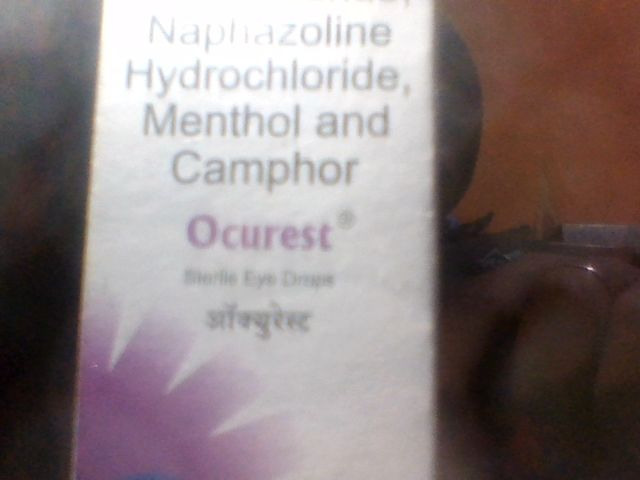

In [ ]:
from IPython.display import Image
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

In [ ]:
import os, sys, subprocess
if "google.colab" in sys.modules:
    cmd = "pip install --upgrade watermark"
    process = subprocess.Popen(cmd.split(), stdout=subprocess.PIPE, stderr=subprocess.PIPE)
    stdout, stderr = process.communicate()

In [ ]:
import os
import sys
import cv2

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

# The coordinates defining the square selected will be kept in this list.
select_coords = []
# While we are in the process of selecting a region, this flag is True.
selecting = False

def get_square_coords(x, y, cx, cy):
    """
    Get the diagonally-opposite coordinates of the square.
    (cx, cy) are the coordinates of the square centre.
    (x, y) is a selected point to which the largest square is to be matched.

    """

    # Selected square edge half-length; don't stray outside the image boundary.
    a = max(abs(cx-x), abs(cy-y))
    a = min(a, w-cx, cx, h-cy, cy)
    return cx-a, cy-a, cx+a, cy+a


def region_selection(event, x, y, flags, param): 
    """Callback function to handle mouse events related to region selection."""
    global select_coords, selecting, image

    if event == cv2.EVENT_LBUTTONDOWN: 
        # Left mouse button down: begin the selection.
        # The first coordinate pair is the centre of the square.
        select_coords = [(x, y)]
        selecting = True

    elif event == cv2.EVENT_MOUSEMOVE and selecting:
        # If we're dragging the selection square, update it.
        image = clone.copy()
        x0, y0, x1, y1 = get_square_coords(x, y, *select_coords[0])
        cv2.rectangle(image, (x0, y0), (x1, y1), (0, 255, 0), 2)

    elif event == cv2.EVENT_LBUTTONUP: 
        # Left mouse button up: the selection has been made.
        select_coords.append((x, y))
        selecting = False


# Load the image and get its filename without path and dimensions.
filename = 'photo.jpg'
basename = os.path.basename(filename)
image = cv2.imread(filename)
h, w = image.shape[:2]
# The cropped image will be saved with this filename.
cropped_filename = os.path.splitext(filename)[0] + '_sq.png'
cropped_basename = os.path.basename(cropped_filename)
# Store a clone of the original image (without selected region annotation).
clone = image.copy() 
# Name the main image window after the image filename.
cv2.namedWindow(basename) 
cv2.setMouseCallback(basename, region_selection)

# Keep looping and listening for user input until 'c' is pressed.
while True: 
    # Display the image and wait for a keypress 
    cv2.imshow(basename, image) 
    key = cv2.waitKey(1) & 0xFF
    # If 'c' is pressed, break from the loop and handle any region selection.
    if key == ord("c"): 
        break

# Did we make a selection?
if len(select_coords) == 2: 
    cx, cy = select_coords[0]
    x, y = select_coords[1]
    x0, y0, x1, y1 = get_square_coords(x, y, cx, cy)
    # Crop the image to the selected region and display in a new window.
    cropped_image = clone[y0:y1, x0:x1]
    cv2.imshow(cropped_basename, cropped_image) 
    cv2.imwrite(cropped_filename, cropped_image)
    # Wait until any key press.
    cv2.waitKey(0)

# We're done: close all open windows before exiting.
cv2.destroyAllWindows()

In [ ]:
from PIL import ImageFont, ImageDraw, Image

filepath = 'photo.jpg'
img = Image.open(filepath)
  
# get width and height
width = img.width
height = img.height

def find_font_size(text, font, image, target_width_ratio):
    tested_font_size = 100
    tested_font = ImageFont.truetype(font, tested_font_size)
    observed_width, observed_height = get_text_size(text, image, tested_font)
    if(observed_width>0):
      estimated_font_size = tested_font_size / (observed_width / width) * target_width_ratio
      return round(estimated_font_size)

def get_text_size(text, image, font):
    im = Image.new('RGB', (width, height))
    draw = ImageDraw.Draw(im)
    return draw.textsize(text, font)

width_ratio = 0.5
font_family = os.path.join("/content/drive/MyDrive/image/arial.ttf")

In [ ]:
import re
import cv2 
import numpy as np
import pytesseract
from pytesseract import Output
from matplotlib import pyplot as plt

In [ ]:
# noise removal
def remove_noise(image):
    return cv2.medianBlur(image,5)
 
#thresholding
def thresholding(image):
    return cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]

#skew correction
def deskew(image):
    coords = np.column_stack(np.where(image > 0))
    angle = cv2.minAreaRect(coords)[-1]
    if angle < -45:
        angle = -(90 + angle)
    else:
        angle = -angle
    (h, w) = image.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated = cv2.warpAffine(image, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)
    return rotated

def image_smoothening(img):
    kernel = np.array([[0, -1, 0],
                   [-1, 5,-1],
                   [0, -1, 0]])
    image_sharp = cv2.filter2D(src=img, ddepth=-1, kernel=kernel)
    return image_sharp

def remove_noise_and_smooth(img):
    # img = cv2.imread(file_name, 0)
    filtered = cv2.adaptiveThreshold(img.astype(np.uint8), 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 9, 41)
    kernel = np.ones((1, 1), np.uint8)
    opening = cv2.morphologyEx(filtered, cv2.MORPH_OPEN, kernel)
    closing = cv2.morphologyEx(opening, cv2.MORPH_CLOSE, kernel)
    img = image_smoothening(img)
    or_image = cv2.bitwise_or(img, closing)
    return or_image

In [ ]:
from PIL import ImageFilter, ImageEnhance
from PIL import ImageChops, Image

from scipy import misc, ndimage

In [ ]:
import imutils

image = Image.open('photo.jpg')

greyscale_image = image.convert('L')
greyscale_image.save('photo.jpg')

Image.open('photo.jpg')

print(image.mode) # Output: RGB
print(greyscale_image.mode) # Output: L

RGB
L


In [ ]:
contrast = ImageEnhance.Contrast(image)
contrast.enhance(3.0).save('photo.jpg')

In [ ]:
brightness = ImageEnhance.Brightness(image)
brightness.enhance(3.0).save('photo.jpg')

In [ ]:
sharpness = ImageEnhance.Sharpness(image)
sharpness.enhance(3.0).save('photo.jpg')

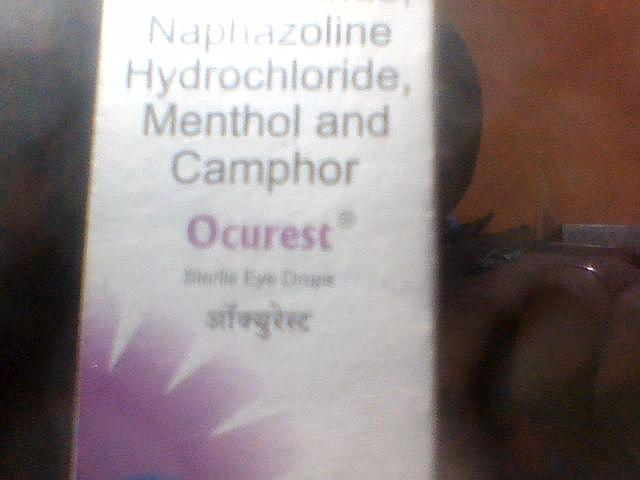

In [ ]:
Image.open('photo.jpg')

In [ ]:
# Get OCR output using Pytesseract
custom_config = r'--oem 3 --psm 6'
str1 = pytesseract.image_to_string(image, lang="eng", config="--psm 6")

In [ ]:
file1 = open('myfile.txt', 'w')
file1.writelines(str1)
file1.close()

In [ ]:
# Using readlines()
file1 = open('myfile.txt', 'r')
Lines = file1.readlines()

In [ ]:
print(Lines)
for line in Lines:
  line = line.strip()
  if line!='':
    line = re.sub('[^A-Za-z0-9]+', ' ', line)
    # pg = result[result['name'].str.contains(line, case=False)]
    pg = result[result['name'].str.contains(line, case=False)]
    print(pg)      

['iL bs\n', '\x0c']
Empty DataFrame
Columns: [name, description]
Index: []


In [ ]:
plt.imshow(gray)

NameError: ignored